# Reducing Failure-Inducing Inputs

By construction, fuzzers create inputs that may be hard to read.  This causes issues during _debugging_, when a human has to analyze the exact cause of the failure.  In this chapter, we present techniques that _automatically reduce and simplify failure-inducing inputs to a minimum_ in order to ease debugging.

**Prerequisites**

* As reduction is typically used together with fuzzing, reading the [chapter on basic fuzzing](Fuzzer.ipynb) is a good idea.
* The simple "delta debugging" technique for reduction has no specific prerequisites.
* The later grammar-based techniques require knowledge on [derivation trees](GrammarFuzzer.ipynb) and [parsing](Parser.ipynb).

## Why Reducing?

At this point, we have seen a number of test generation techniques that all in some form produce inputs in order to trigger failures.  If they are successful – that is, the program actually fails – we must find out why the failure occurred and how to fix it.

Here's an example of such a situation.  We have a class `MysteryRunner` class with a `run()` method that – given its code – can occasionally fail.  But under which circumstances does this actually happen?  We have deliberately obscured the exact condition in order to make this non-obvious.

In [1]:
import fuzzingbook_utils

In [2]:
from Fuzzer import RandomFuzzer, Runner

In [3]:
import re

In [4]:
class MysteryRunner(Runner):
    def run(self, inp):
        x = inp.find(chr(0o17 + 0o31))
        y = inp.find(chr(0o27 + 0o22))
        if x >= 0 and y >= 0 and x < y:
            return (inp, Runner.FAIL)
        else:
            return (inp, Runner.PASS)

Let us fuzz the function until we find a failing input.

In [5]:
mystery = MysteryRunner()
random_fuzzer = RandomFuzzer()
while True:
    inp = random_fuzzer.fuzz()
    result, outcome = mystery.run(inp)
    if outcome == mystery.FAIL:
        break

In [6]:
failing_input = result
failing_input

' 7:,>((/$$-/->.;.=;(.%!:50#7*8=$&&=$9!%6(4=&69\':\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#'

Something in this input causes `MysteryRunner` to fail.  But what is it?

## Manual Input Reduction

One important step in the debugging process is _reduction_ – that is, to identify those circumstances of a failure that are relevant for the failure to occur, and to _omit_ (if possible) those parts that are not.  As Kernighan and Pike \cite{Kernighan1999} put it:

> For every circumstance of the problem, check whether it is relevant for the problem to occur.  If it is not, remove it from the problem report or the test case in question.

Specifically for inputs, they suggest a _divide and conquer_ process:

> Proceed by binary search.  Throw away half the input and see if the output is still wrong; if not, go back to the previous state and discard the other half of the input.

This is something we can easily try out.  For instance, we can see whether the error still occurs if we only feed in the first half:

In [7]:
half_length = len(failing_input) // 2   # // is integer division
first_half = failing_input[:half_length]
mystery.run(first_half)

(" 7:,>((/$$-/->.;.=;(.%!:50#7*8=$&&=$9!%6(4=&69':", 'PASS')

Nope – the first half alone does not suffice.  Maybe the second half?

In [8]:
second_half = failing_input[half_length:]
mystery.run(second_half)

('\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#', 'PASS')

This did not go so well either.  We may still proceed by cutting away _smaller chunks_ – say, one character after another.  If our test is deterministic and easily repeated, it is clear that this process eventually will yield a reduced input.  But still, it is a rather inefficient process, especially for long inputs.  What we need is a _strategy_ that effectively minimizes a failure-inducing input – a strategy that can be automated.

## Delta Debugging

One strategy to effectively reduce failure-inducing inputs is _delta debugging_ \cite{Zeller2002}.  Delta Debugging implements the "binary search" strategy, as listed above, but with a twist: If neither half fails (also as above), it keeps on cutting away smaller and smaller chunks from the input, until it eliminates individual characters.  Thus, after cutting away the first half, we cut away
the first quarter, the second quarter, and so on.

Let us illustrate this on our example, and see what happens if we cut away the first quarter.

In [9]:
quarter_length = len(failing_input) // 4
input_without_first_quarter = failing_input[quarter_length:]
mystery.run(input_without_first_quarter)

('50#7*8=$&&=$9!%6(4=&69\':\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#',
 'FAIL')

Ah! This has failed, and reduced our failing input by 25%.  Let's remove another quarter.

In [10]:
input_without_first_and_second_quarter = failing_input[quarter_length * 2:]
mystery.run(input_without_first_and_second_quarter)

('\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#', 'PASS')

This is not too surprising, as we had that one before:

In [11]:
second_half

'\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#'

In [12]:
input_without_first_and_second_quarter

'\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#'

How about removing the third quarter, then?

In [13]:
input_without_first_and_third_quarter = failing_input[quarter_length:
                                                      quarter_length * 2] + failing_input[quarter_length * 3:]
mystery.run(input_without_first_and_third_quarter)

("50#7*8=$&&=$9!%6(4=&69':<7+1<2!4$>92+$1<(3%&5''>#", 'PASS')

How about removing the third quarter, then?

In [14]:
input_without_first_and_fourth_quarter = failing_input[quarter_length:quarter_length * 3]
mystery.run(input_without_first_and_fourth_quarter)

('50#7*8=$&&=$9!%6(4=&69\':\'<3+0-3.24#7=!&60)2/+";+', 'FAIL')

Yes!  This has succeeded.  Our input is now 50% smaller.

We have now tried to remove pieces that make up $\frac{1}{2}$ and $\frac{1}{4}$ of the original failing string.  In the next iteration, we would go and remove even smaller pieces – $\frac{1}{8}$, $\frac{1}{16}$ and so on.  We continue until we are down to $\frac{1}{97}$ – that is, individual characters.

However, this is comething we happily let a computer do for us.  We first introduce a `Reducer` class as an abstract superclass for all kinds of reducers.  The `test()` methods runs a single test (with logging, if so wanted); the `reduce()` method will eventually reduce an input to the minimum.

In [15]:
class Reducer(object):
    def __init__(self, runner, log_test=False):
        """Attach reducer to the given `runner`"""
        self.runner = runner
        self.log_test = log_test
        self.reset()

    def reset(self):
        self.tests = 0

    def test(self, inp):
        result, outcome = self.runner.run(inp)
        self.tests += 1
        if self.log_test:
            print("Test #%d" % self.tests, repr(inp), repr(len(inp)), outcome)
        return outcome

    def reduce(self, inp):
        self.reset()
        # Default: Don't reduce
        return inp

The `CachingReducer` variant saves test results, such that we don't have to run the same tests again and again:

In [16]:
class CachingReducer(Reducer):
    def reset(self):
        super().reset()
        self.cache = {}

    def test(self, inp):
        if inp in self.cache:
            return self.cache[inp]

        outcome = super().test(inp)
        self.cache[inp] = outcome
        return outcome

Here comes the _Delta Debugging_ reducer.  Delta Debugging implements the strategy sketched above: It first removes larger chunks of size $\frac{1}{2}$; if this does not fail, then we proceed to chunks of size $\frac{1}{4}$, then $\frac{1}{8}$ and so on.

Our implementation uses almost the same Python code as Zeller in \cite{Zeller2011}; the only difference is that it has been adapted to work on Python 3 and our `Runner` framework.    The variable `n` (initially 2) indicates the granularity – in each step, chunks of size $\frac{1}{n}$ are cut away.  If none of the test fails (`some_complement_is_failing` is False), then `n` is doubled – until it reaches the length of the input.

In [17]:
class DeltaDebuggingReducer(CachingReducer):
    def reduce(self, inp):
        self.reset()
        assert self.test(inp) != Runner.PASS

        n = 2     # Initial granularity
        while len(inp) >= 2:
            start = 0
            subset_length = len(inp) / n
            some_complement_is_failing = False

            while start < len(inp):
                complement = inp[:int(start)] + \
                    inp[int(start + subset_length):]

                if self.test(complement) == Runner.FAIL:
                    inp = complement
                    n = max(n - 1, 2)
                    some_complement_is_failing = True
                    break

                start += subset_length

            if not some_complement_is_failing:
                if n == len(inp):
                    break
                n = min(n * 2, len(inp))

        return inp

To see how the `DeltaDebuggingReducer` works, let us run it on our failing input.  With each step, we see how the remaining input gets smaller and smaller, until only three characters remain:

In [18]:
dd_reducer = DeltaDebuggingReducer(mystery, log_test=True)
dd_reducer.reduce(failing_input)

Test #1 ' 7:,>((/$$-/->.;.=;(.%!:50#7*8=$&&=$9!%6(4=&69\':\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#' 97 FAIL
Test #2 '\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#' 49 PASS
Test #3 " 7:,>((/$$-/->.;.=;(.%!:50#7*8=$&&=$9!%6(4=&69':" 48 PASS
Test #4 '50#7*8=$&&=$9!%6(4=&69\':\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#' 73 FAIL
Test #5 "50#7*8=$&&=$9!%6(4=&69':<7+1<2!4$>92+$1<(3%&5''>#" 49 PASS
Test #6 '50#7*8=$&&=$9!%6(4=&69\':\'<3+0-3.24#7=!&60)2/+";+' 48 FAIL
Test #7 '\'<3+0-3.24#7=!&60)2/+";+' 24 PASS
Test #8 "50#7*8=$&&=$9!%6(4=&69':" 24 PASS
Test #9 '9!%6(4=&69\':\'<3+0-3.24#7=!&60)2/+";+' 36 FAIL
Test #10 '9!%6(4=&69\':=!&60)2/+";+' 24 FAIL
Test #11 '=!&60)2/+";+' 12 PASS
Test #12 "9!%6(4=&69':" 12 PASS
Test #13 '=&69\':=!&60)2/+";+' 18 PASS
Test #14 '9!%6(4=!&60)2/+";+' 18 FAIL
Test #15 '9!%6(42/+";+' 12 PASS
Test #16 '9!%6(4=!&60)' 12 FAIL
Test #17 '=!&60)' 6 PASS
Test #18 '9!%6(4' 6 PASS
Test #19 '6(4=!&60)' 9 FAIL
Test #20 '6(460)' 6 FAIL
Test #21 '60

'()'

Now we know why `MysteryRunner` fails – it suffices that the input contains two matching parentheses with a number between them.  Delta Debugging determines this is 29 steps.  Its result is _1-minimal_, meaning that every character contained is required to produce the error; removing any (as seen in tests `#27` and `#28`, above) no longer makes the test fail.  This property is guaranteed by the delta debugging algorithm, which in its last stage always tries to delete characters one by one.

A reduced test case such as the one above has many advantages:

* A reduced test case __reduces the _cognitive load_ of the programmer__.  The test case is shorter and focused, and thus does not burden the programmer with irrelevant details.  A reduced input typically leads to shorter executions and smaller program states, both of which reduce the search space as it comes to understanding the bug.  In our case, we have eliminated lots of irrelevant input – only the two characters the reduced input contains are relevant.

* A reduced test case __is easier to communicate__.  All one needs here is the summary: `MysteryRunner fails on "()"`, which is much better than `MysteryRunner fails on a 4100-character input (attached)`.

* A reduced test case helps in __identifying duplicates__.  If similar bugs have been reported already, and all of them have been reduced to the same cause (namely that the input contains matching parentheses), then it becomes obvious that all these bugs are different symptoms of the same underlying cause – and would all be resolved at once with one code fix.

How effective is delta debugging?  In the best case (when the left half or the right half fails), the number of tests is logarithmic proportional to the length $n$ of an input (i.e., $O(\log_2 n)$); this is the same complexity as binary search.  In the worst case, though, delta debugging can require a number of tests proportional to $n^2$  (i.e., $O(n^2)$) – this happens in the case when we are down to character granularity, and we have to repeatedly tried to delete all characters, only to find that deleting the last character results in a failure \cite{Zeller2002}.  (This is a pretty pathological situation, though.)

In general, delta debugging is a very robust algorithm that is easy to implement, easy to deploy, and easy to use – provided that the underlying test case is deterministic and runs quickly enough to warrant a number of experiments.  As these are the same prerequisites that make fuzzing effective, delta debugging makes an excellent companion to fuzzing.

## Grammar-Based Input Reduction

In the second half of this chapter, we will introduce an algorithm that makes use of _grammars_ to reduce inputs even faster.  The general idea is to start with a _derivation tree_, and then substitute subtrees by smaller subtrees of the same type.  These alternate subtrees can either come

1. From the tree itself, or
2. By applying an alternate grammar expansion using elements from the tree.

Let us show these two strategies using an example.  We start with a derivation tree from an arithmetic expression:

In [19]:
from Parser import EarleyParser

In [20]:
from GrammarFuzzer import all_terminals, expansion_to_children, display_tree

In [21]:
from Grammars import EXPR_GRAMMAR, nonterminals

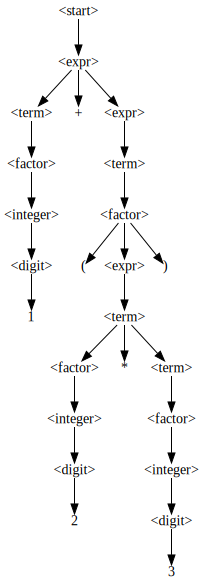

In [22]:
inp = "1 + (2 * 3)"
derivation_tree = EarleyParser(EXPR_GRAMMAR).parse(inp)[0]
display_tree(derivation_tree)

### Simplifying by Replacing Subtrees

To simplify this tree, we could replace any `<expr>` symbol up in the tree with some `<expr>` subtree down in the tree.  For instance, we could replace the uppermost `<expr>` with its right `<expr>` subtree, yielding the string `(2 + 3)`:

In [23]:
import copy

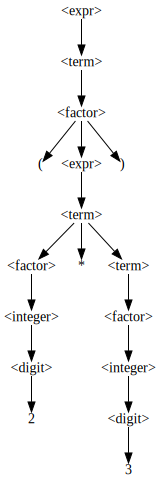

In [24]:
new_derivation_tree = copy.deepcopy(derivation_tree)
sub_expr_tree = new_derivation_tree[1][0][1][2]  # We really should have some query language
display_tree(sub_expr_tree)

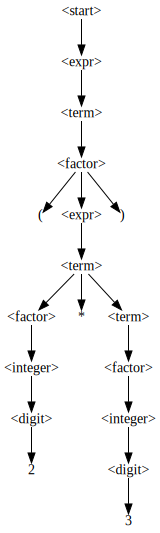

In [25]:
new_derivation_tree[1][0] = sub_expr_tree
display_tree(new_derivation_tree)

In [26]:
all_terminals(new_derivation_tree)

'(2 * 3)'

Replacing one subtree by another only works as long as individual elements such as `<expr>` occur multiple times in our tree.  In the reduced `new_derivation_tree`, above, we could replace further `<expr>` trees only once more.

### Simplifying by Alternative Expansions

A second means to simplify this tree is to apply _alternative expansions_.  That is, for a symbol, we check whether there is an alternative expansion with a smaller number of children.  Then, we replace the symbol with the alternative expansion, filling in needed symbols from the tree.

As an example, consider the `new_derivation_tree` above.  The applied expansion for `<term>` has been

    <term> ::= <term> * <factor>
    
Lat us replace this with the alternative expansion:

    <term> ::= <factor>

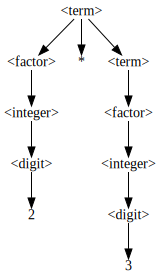

In [27]:
term_tree = new_derivation_tree[1][0][1][0][1][0][1][1][1][0]
display_tree(term_tree)

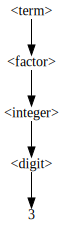

In [28]:
shorter_term_tree = term_tree[1][2]
display_tree(shorter_term_tree)

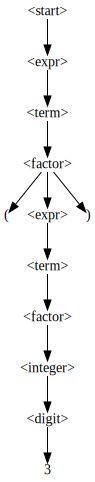

In [29]:
new_derivation_tree[1][0][1][0][1][0][1][1][1][0] = shorter_term_tree
display_tree(new_derivation_tree)

In [30]:
all_terminals(new_derivation_tree)

'(3)'

If we replace derivation subtrees by (smaller) subtrees, and if we search for alternate expansions that again yield smaller subtrees, we can systematically simplify the input.  This could be much faster than delta debugging, as our inputs would always be syntactically valid.  However, we need a strategy for when to apply which simplification rule. This is what we develop in the remainder of this section.

### A Class for Reducing with Grammars

We introduce the `GrammarReducer` class, which is again a `Reducer`.  Note that we derive from `CachingReducer`, as the strategy will produce several duplicates.

In [31]:
class GrammarReducer(CachingReducer):
    def __init__(self, runner, parser, log_test=False, log_reduce=False):
        super().__init__(runner, log_test=log_test)
        self.parser = parser
        self.grammar = parser.grammar()
        self.start_symbol = parser.start_symbol()
        self.log_reduce = log_reduce
        self.try_all_combinations = False

### A Few Helpers

In [32]:
def tree_list_to_string(q):
    return "[" + ", ".join([all_terminals(tree) for tree in q]) + "]"

In [33]:
tree_list_to_string([derivation_tree, derivation_tree])

'[1 + (2 * 3), 1 + (2 * 3)]'

In [34]:
def possible_combinations(list_of_lists):
    # convert a list [[X1, X2], [Y1, Y2], ...]
    # into [X1, Y1], [X1, Y2], [X2, Y1], [X2, Y2], ...
    if len(list_of_lists) == 0:
        return []

    # print(list_of_lists)

    ret = []
    for e in list_of_lists[0]:
        if len(list_of_lists) == 1:
            ret.append([e])
        else:
            for c in possible_combinations(list_of_lists[1:]):
                new_combo = [e] + c
                ret.append(new_combo)
    return ret

In [35]:
possible_combinations([[1, 2], ['a', 'b']])

[[1, 'a'], [1, 'b'], [2, 'a'], [2, 'b']]

In [36]:
# Return the number of nodes
def number_of_nodes(tree):
    (symbol, children) = tree
    return 1 + sum([number_of_nodes(c) for c in children])

In [37]:
number_of_nodes(derivation_tree)

25

In [38]:
# Return height of a tree
def max_height(tree):
    (symbol, children) = tree
    if len(children) == 0:
        return 1
    return 1 + max([max_height(c) for c in children])

In [39]:
max_height(derivation_tree)

12

### Simplification Strategies

#### Finding Symbols

In [40]:
class GrammarReducer(GrammarReducer):
    def subtrees_with_symbol(self, tree, symbol, depth=-1, ignore_root=True):
        # Find all subtrees in TREE whose root is SYMBOL.
        # If IGNORE_ROOT is true, ignore the root note of TREE.

        ret = []
        (child_symbol, children) = tree
        if depth <= 0 and not ignore_root and child_symbol == symbol:
            ret.append(tree)

        # Search across all children
        if depth != 0 and children is not None:
            for c in children:
                ret += self.subtrees_with_symbol(c, symbol, depth=depth - 1, ignore_root=False)

        return ret

In [41]:
grammar_reducer = GrammarReducer(mystery, EarleyParser(EXPR_GRAMMAR), log_reduce=True)

In [42]:
[all_terminals(t) for t in grammar_reducer.subtrees_with_symbol(derivation_tree, "<term>")]

['1', '(2 * 3)', '2 * 3', '3']

#### Alternate Expansions

In [43]:
class GrammarReducer(GrammarReducer):
    def alternate_reductions(self, tree, symbol, depth=-1):
        reductions = []
        
        expansions = self.grammar.get(symbol, [])
        expansions.sort(key=lambda expansion: len(expansion_to_children(expansion)))

        for expansion in expansions:
            expansion_children = expansion_to_children(expansion)

            match = True
            new_children_reductions = []
            for (alt_symbol, _) in expansion_children:
                child_reductions = self.subtrees_with_symbol(tree, alt_symbol, depth=depth)
                if len(child_reductions) == 0:
                    match = False   # Child not found; cannot apply rule
                    break

                new_children_reductions.append(child_reductions)

            if not match:
                continue  # Try next alternative

            # Use the first suitable combination
            for new_children in possible_combinations(new_children_reductions):
                new_tree = (symbol, new_children)
                if number_of_nodes(new_tree) < number_of_nodes(tree):
                    reductions.append(new_tree)
                    if not self.try_all_combinations:
                        break

        # Sort by number of nodes
        reductions.sort(key=number_of_nodes)
        
        return reductions

#### Both Strategies Together

In [44]:
class GrammarReducer(GrammarReducer):
    def symbol_reductions(self, tree, symbol, depth=-1):
        """Find all expansion alternatives for the given symbol"""
        reductions = (self.subtrees_with_symbol(tree, symbol, depth=depth)
                      + self.alternate_reductions(tree, symbol, depth=depth))

        # Filter duplicates
        unique_reductions = []
        for r in reductions:
            if r not in unique_reductions:
                unique_reductions.append(r)

        return unique_reductions

In [45]:
grammar_reducer = GrammarReducer(mystery, EarleyParser(EXPR_GRAMMAR), log_reduce=True)

In [46]:
all_terminals(derivation_tree)

'1 + (2 * 3)'

In [47]:
reductions = grammar_reducer.symbol_reductions(derivation_tree, "<expr>")
tree_list_to_string([r for r in reductions])

'[1 + (2 * 3), (2 * 3), 2 * 3, 1]'

In [48]:
reductions = grammar_reducer.symbol_reductions(derivation_tree, "<factor>")
tree_list_to_string([r for r in reductions])

'[1, (2 * 3), 2, 3, ((2 * 3))]'

### A Reduction Strategy

In [49]:
class GrammarReducer(GrammarReducer):
    def reduce_subtree(self, tree, subtree, depth):
        symbol, children = subtree
        if len(children) == 0:
            return

        if self.log_reduce:
            print("Reducing", all_terminals(subtree), "with depth", depth)

        while True:
            reduced = False
            for i, child in enumerate(children):
                (child_symbol, _) = child
                for reduction in self.symbol_reductions(child, child_symbol, depth):
                    if number_of_nodes(reduction) >= number_of_nodes(child):
                        continue

                    # Try this reduction
                    if self.log_reduce:
                        print("Replacing", all_terminals(children[i]), "by", all_terminals(reduction))
                    children[i] = reduction
                    if self.test(all_terminals(tree)) == Runner.FAIL:
                        # Success
                        if self.log_reduce:
                            print("New tree:", all_terminals(tree))
                        reduced = True
                        break
                    else:
                        # Didn't work out - restore
                        children[i] = child

            if not reduced:
                if self.log_reduce:
                    print("Tried all alternatives for", all_terminals(subtree))
                break

        # Run recursively
        for c in children:
            self.reduce_subtree(tree, c, depth)

In [50]:
class GrammarReducer(GrammarReducer):
    def reduce_tree(self, tree):
        for depth in range(max_height(tree)):
            self.reduce_subtree(tree, tree, depth)
        return tree        

### Putting Things Together

In [51]:
class GrammarReducer(GrammarReducer):
    def parse(self, inp):
        tree = self.parser.parse(inp)[0]
        print(all_terminals(tree))
        return tree

    def reduce(self, inp):
        tree = self.parse(inp)
        smallest_tree = self.reduce_tree(tree)
        return all_terminals(smallest_tree)

In [52]:
grammar_reducer = GrammarReducer(mystery, EarleyParser(EXPR_GRAMMAR), log_test=True)
grammar_reducer.reduce(inp)

1 + (2 * 3)
Test #1 '(2 * 3)' 7 FAIL
Test #2 '(3)' 3 FAIL
Test #3 '3' 1 PASS


'(3)'

In [53]:
dd_reducer = DeltaDebuggingReducer(mystery, log_test=True)
dd_reducer.reduce(inp)

Test #1 '1 + (2 * 3)' 11 FAIL
Test #2 '2 * 3)' 6 PASS
Test #3 '1 + (' 5 PASS
Test #4 '+ (2 * 3)' 9 FAIL
Test #5 '+ ( 3)' 6 FAIL
Test #6 ' 3)' 3 PASS
Test #7 '+ (' 3 PASS
Test #8 ' ( 3)' 5 FAIL
Test #9 '( 3)' 4 FAIL
Test #10 '3)' 2 PASS
Test #11 '( ' 2 PASS
Test #12 '(3)' 3 FAIL
Test #13 '()' 2 FAIL
Test #14 ')' 1 PASS
Test #15 '(' 1 PASS


'()'

We see that the grammar-based reducer needs far fewer steps.  (On the other hand, the delta debugging reducer can reduce a bit further, as it is not bound by the grammar.)

In [54]:
from GrammarFuzzer import GrammarFuzzer

In [55]:
inp = GrammarFuzzer(EXPR_GRAMMAR, min_nonterminals=100).fuzz()
inp

'++---((-2 / 3 / 3 - -+1 / 5 - 2) * ++6 / +8 * 4 / 9 / 2 * 8 + ++(5) * 3 / 8 * 0 + 3 * 3 + 4 / 0 / 6 + 9) * ++++(+--9 * -3 * 7 / 4 + --(4) / 3 - 0 / 3 + 5 + 0) * (1 * 6 - 1 / 9 * 5 - 9 / 0 + 7) * ++(8 - 1) * +1 * 7 * 0 + ((1 + 4) / 4 * 8 * 9 * 4 + 4 / (4) * 1 - (4) * 8 * 5 + 1 + 4) / (+(2 - 1 - 9) * 5 + 3 + 6 - 2) * +3 * (3 - 7 + 8) / 4 - -(9 * 4 - 1 * 0 + 5) / (5 / 9 * 5 + 2) * 7 + ((7 - 5 + 3) / 1 * 8 - 8 - 9) * --+1 * 4 / 4 - 4 / 7 * 4 - 3 / 6 * 1 - 2 - 7 - 8'

In [56]:
grammar_reducer = GrammarReducer(mystery, EarleyParser(EXPR_GRAMMAR), log_test=True)
grammar_reducer.reduce(inp)

++---((-2 / 3 / 3 - -+1 / 5 - 2) * ++6 / +8 * 4 / 9 / 2 * 8 + ++(5) * 3 / 8 * 0 + 3 * 3 + 4 / 0 / 6 + 9) * ++++(+--9 * -3 * 7 / 4 + --(4) / 3 - 0 / 3 + 5 + 0) * (1 * 6 - 1 / 9 * 5 - 9 / 0 + 7) * ++(8 - 1) * +1 * 7 * 0 + ((1 + 4) / 4 * 8 * 9 * 4 + 4 / (4) * 1 - (4) * 8 * 5 + 1 + 4) / (+(2 - 1 - 9) * 5 + 3 + 6 - 2) * +3 * (3 - 7 + 8) / 4 - -(9 * 4 - 1 * 0 + 5) / (5 / 9 * 5 + 2) * 7 + ((7 - 5 + 3) / 1 * 8 - 8 - 9) * --+1 * 4 / 4 - 4 / 7 * 4 - 3 / 6 * 1 - 2 - 7 - 8
Test #1 '((1 + 4) / 4 * 8 * 9 * 4 + 4 / (4) * 1 - (4) * 8 * 5 + 1 + 4) / (+(2 - 1 - 9) * 5 + 3 + 6 - 2) * +3 * (3 - 7 + 8) / 4 - -(9 * 4 - 1 * 0 + 5) / (5 / 9 * 5 + 2) * 7 + ((7 - 5 + 3) / 1 * 8 - 8 - 9) * --+1 * 4 / 4 - 4 / 7 * 4 - 3 / 6 * 1 - 2 - 7 - 8' 245 FAIL
Test #2 '-(9 * 4 - 1 * 0 + 5) / (5 / 9 * 5 + 2) * 7 + ((7 - 5 + 3) / 1 * 8 - 8 - 9) * --+1 * 4 / 4 - 4 / 7 * 4 - 3 / 6 * 1 - 2 - 7 - 8' 125 FAIL
Test #3 '((7 - 5 + 3) / 1 * 8 - 8 - 9) * --+1 * 4 / 4 - 4 / 7 * 4 - 3 / 6 * 1 - 2 - 7 - 8' 80 FAIL
Test #4 '4 / 7 * 4 - 3 / 

'(9)'

In [57]:
dd_reducer = DeltaDebuggingReducer(mystery, log_test=True)
dd_reducer.reduce(inp)

Test #1 '++---((-2 / 3 / 3 - -+1 / 5 - 2) * ++6 / +8 * 4 / 9 / 2 * 8 + ++(5) * 3 / 8 * 0 + 3 * 3 + 4 / 0 / 6 + 9) * ++++(+--9 * -3 * 7 / 4 + --(4) / 3 - 0 / 3 + 5 + 0) * (1 * 6 - 1 / 9 * 5 - 9 / 0 + 7) * ++(8 - 1) * +1 * 7 * 0 + ((1 + 4) / 4 * 8 * 9 * 4 + 4 / (4) * 1 - (4) * 8 * 5 + 1 + 4) / (+(2 - 1 - 9) * 5 + 3 + 6 - 2) * +3 * (3 - 7 + 8) / 4 - -(9 * 4 - 1 * 0 + 5) / (5 / 9 * 5 + 2) * 7 + ((7 - 5 + 3) / 1 * 8 - 8 - 9) * --+1 * 4 / 4 - 4 / 7 * 4 - 3 / 6 * 1 - 2 - 7 - 8' 465 FAIL
Test #2 ' * 8 * 9 * 4 + 4 / (4) * 1 - (4) * 8 * 5 + 1 + 4) / (+(2 - 1 - 9) * 5 + 3 + 6 - 2) * +3 * (3 - 7 + 8) / 4 - -(9 * 4 - 1 * 0 + 5) / (5 / 9 * 5 + 2) * 7 + ((7 - 5 + 3) / 1 * 8 - 8 - 9) * --+1 * 4 / 4 - 4 / 7 * 4 - 3 / 6 * 1 - 2 - 7 - 8' 233 FAIL
Test #3 '- 1 * 0 + 5) / (5 / 9 * 5 + 2) * 7 + ((7 - 5 + 3) / 1 * 8 - 8 - 9) * --+1 * 4 / 4 - 4 / 7 * 4 - 3 / 6 * 1 - 2 - 7 - 8' 117 PASS
Test #4 ' * 8 * 9 * 4 + 4 / (4) * 1 - (4) * 8 * 5 + 1 + 4) / (+(2 - 1 - 9) * 5 + 3 + 6 - 2) * +3 * (3 - 7 + 8) / 4 - -(9 * 4 

'()'

As above: It pays off to use grammars.

### Complex Inputs

The more complex the input, the better off we are with grammar-based reduction.

In [58]:
from GeneratorGrammarFuzzer import GeneratorGrammarFuzzer, CONSTRAINED_VAR_GRAMMAR

In [59]:
class EvalMysteryRunner(MysteryRunner):
    def __init__(self):
        self.parser = EarleyParser(CONSTRAINED_VAR_GRAMMAR)
    def run(self, inp):
        try:
            tree = self.parser.parse(inp)[0]
        except SyntaxError:
            return (inp, Runner.UNRESOLVED)
        
        return super().run(inp)

In [60]:
eval_mystery = EvalMysteryRunner()

In [61]:
var_fuzzer = GeneratorGrammarFuzzer(CONSTRAINED_VAR_GRAMMAR)
while True:
    inp = var_fuzzer.fuzz()
    print(inp)
    if eval_mystery.run(inp)[1] == Runner.FAIL:
        break
inp

W=-9.869
j=(+1.8*++(2+6))*-++++-+3/(9+1*+7/3/3)


'j=(+1.8*++(2+6))*-++++-+3/(9+1*+7/3/3)'

In [62]:
grammar_reducer = GrammarReducer(eval_mystery, EarleyParser(CONSTRAINED_VAR_GRAMMAR), log_test=True)
grammar_reducer.reduce(inp)

j=(+1.8*++(2+6))*-++++-+3/(9+1*+7/3/3)
Test #1 'j=-++++-+3/(9+1*+7/3/3)' 23 FAIL
Test #2 'j=(9+1*+7/3/3)' 14 FAIL
Test #3 'j=(1*+7/3/3)' 12 FAIL
Test #4 'j=(+7/3/3)' 10 FAIL
Test #5 'j=(3/3)' 7 FAIL
Test #6 'j=(3)' 5 FAIL
Test #7 'j=3' 3 PASS


'j=(3)'

In [63]:
dd_reducer = DeltaDebuggingReducer(eval_mystery, EarleyParser(CONSTRAINED_VAR_GRAMMAR))
dd_reducer.reduce(inp)

Test #1 'j=(+1.8*++(2+6))*-++++-+3/(9+1*+7/3/3)' 38 FAIL
Test #2 '+++-+3/(9+1*+7/3/3)' 19 UNRESOLVED
Test #3 'j=(+1.8*++(2+6))*-+' 19 UNRESOLVED
Test #4 '+(2+6))*-++++-+3/(9+1*+7/3/3)' 29 UNRESOLVED
Test #5 'j=(+1.8*++++-+3/(9+1*+7/3/3)' 28 UNRESOLVED
Test #6 'j=(+1.8*++(2+6))*-++1*+7/3/3)' 29 UNRESOLVED
Test #7 'j=(+1.8*++(2+6))*-++++-+3/(9' 28 UNRESOLVED
Test #8 '1.8*++(2+6))*-++++-+3/(9+1*+7/3/3)' 34 UNRESOLVED
Test #9 'j=(++(2+6))*-++++-+3/(9+1*+7/3/3)' 33 FAIL
Test #10 'j=(+))*-++++-+3/(9+1*+7/3/3)' 28 UNRESOLVED
Test #11 'j=(++(2+6+++-+3/(9+1*+7/3/3)' 28 UNRESOLVED
Test #12 'j=(++(2+6))*-++3/(9+1*+7/3/3)' 29 FAIL
Test #13 '+(2+6))*-++3/(9+1*+7/3/3)' 25 UNRESOLVED
Test #14 'j=(+))*-++3/(9+1*+7/3/3)' 24 UNRESOLVED
Test #15 'j=(++(2+6+3/(9+1*+7/3/3)' 24 UNRESOLVED
Test #16 'j=(++(2+6))*-++1*+7/3/3)' 24 UNRESOLVED
Test #17 'j=(++(2+6))*-++3/(9/3/3)' 24 FAIL
Test #18 '+(2+6))*-++3/(9/3/3)' 20 UNRESOLVED
Test #19 'j=(+))*-++3/(9/3/3)' 19 UNRESOLVED
Test #20 'j=(++(2+6+3/(9/3/3)' 19 UNR

'j=((2))/(3)'

Not only does grammar-based reduction need far fewer tests, the reduced result is also smaller.

## Lessons Learned

* Reducing failure-inducing inputs to a minimum is helpful for testing and debugging.
* _Delta Debugging_ is a simple and robust algorithm to easily reduce test cases.
* For complex inputs, consider _grammar-based_ reduction instead.

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

The delta debugging algorithm discussed here stems from \cite{Zeller2002}; actually, this is the exact Python implementation as used by Zeller in 2002.  The idea of systematically reducing inputs has been discovered a number of times, although not as  automatic and generic as delta debugging. \cite{Slutz1998}, for instance, discusses systematic reduction of SQL statements for SQL databases; the general process as manual work is well described by \cite{Kernighan1999}.

\cite{Herfert2017}

\todo{Discuss hierarchical DD, Csmith / C-reduce}


## Exercises

Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with

```markdown
**Solution.**
```

Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`).

Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution.

### Exercise 1: _Title_

_Text of the exercise_

In [64]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [65]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

**Solution.** _Solution for the exercise_